![image.png](attachment:image.png)

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy import stats

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df = pd.read_csv('/content/drive/MyDrive/online_shoppers_intention.csv')

In [78]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [79]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [80]:
# Faça mais algum tratamento nas variáveis caso ache pertinente

df[['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = df[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype(str)

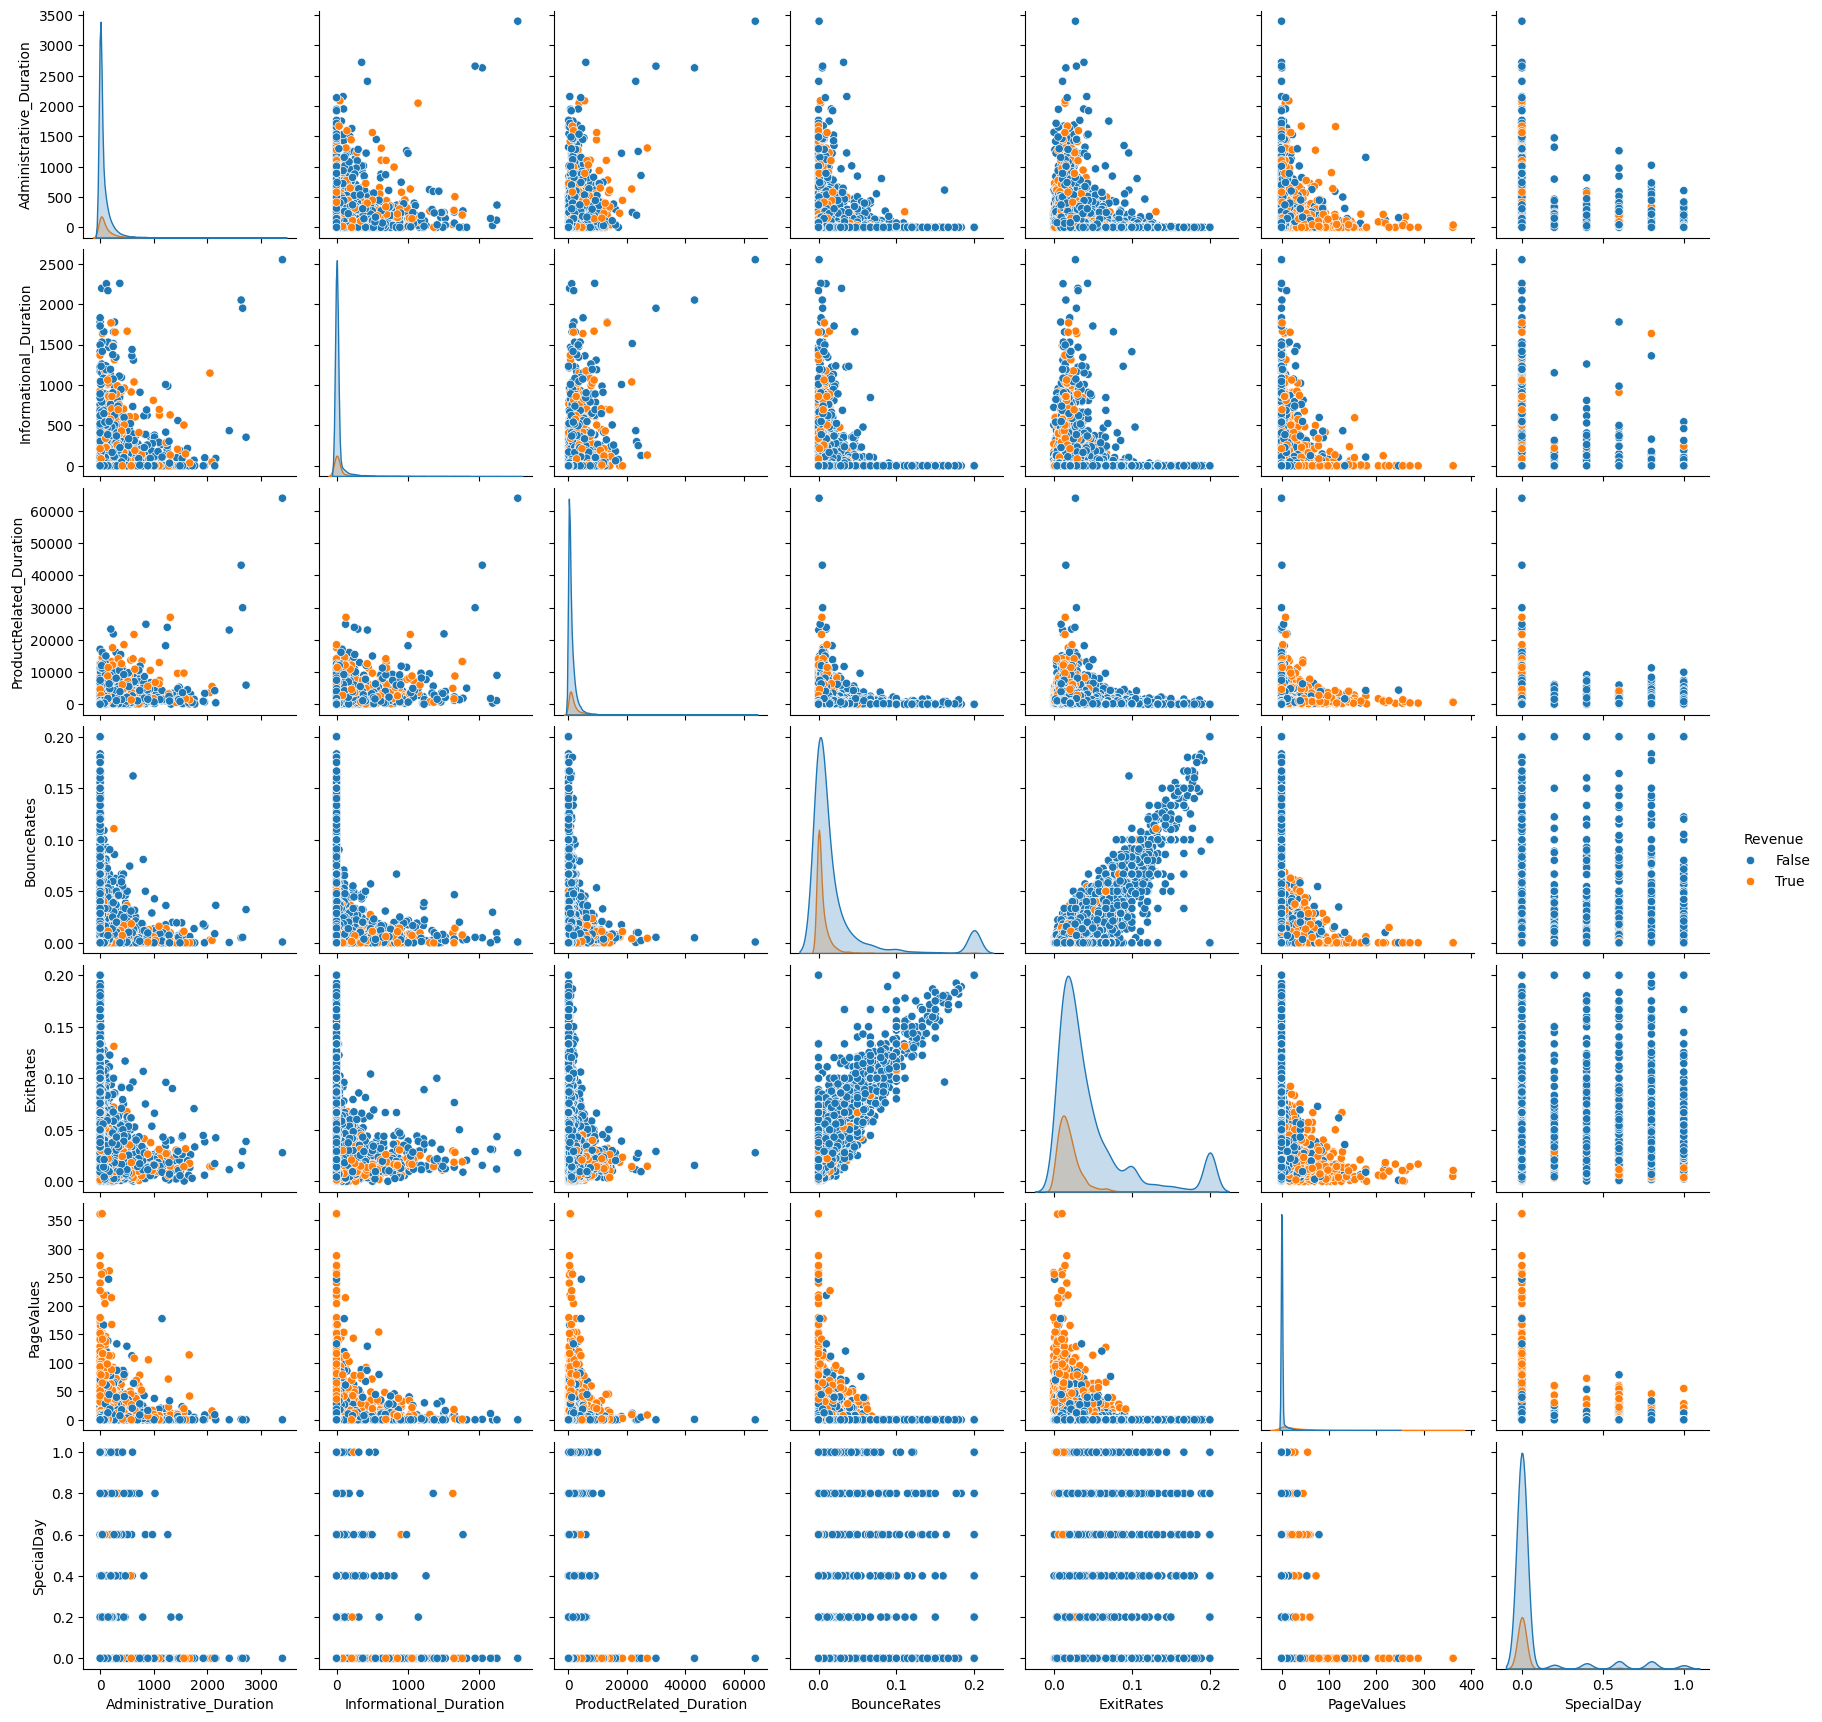

In [81]:
# distribuição das variáveis tipo float

float_cols = list(df.select_dtypes(include=['float64']).columns) + ['Revenue']

sns.pairplot(data=df[float_cols], hue='Revenue')

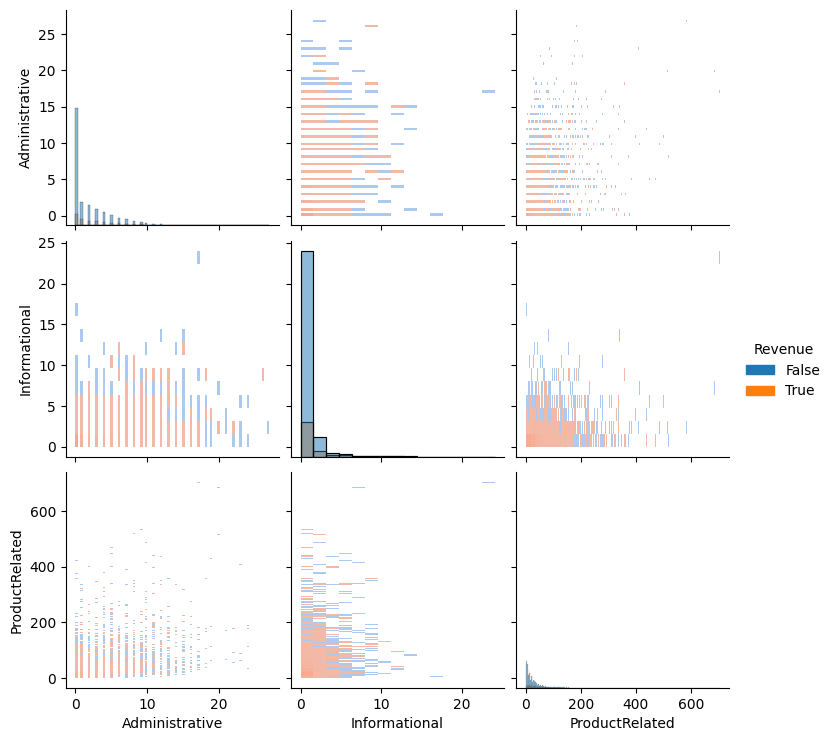

In [82]:
# distribuição das variáveis tipo int

int_cols = list(df.select_dtypes(include=['int64']).columns) + ['Revenue']

sns.pairplot(data=df[int_cols], hue='Revenue', kind='hist')

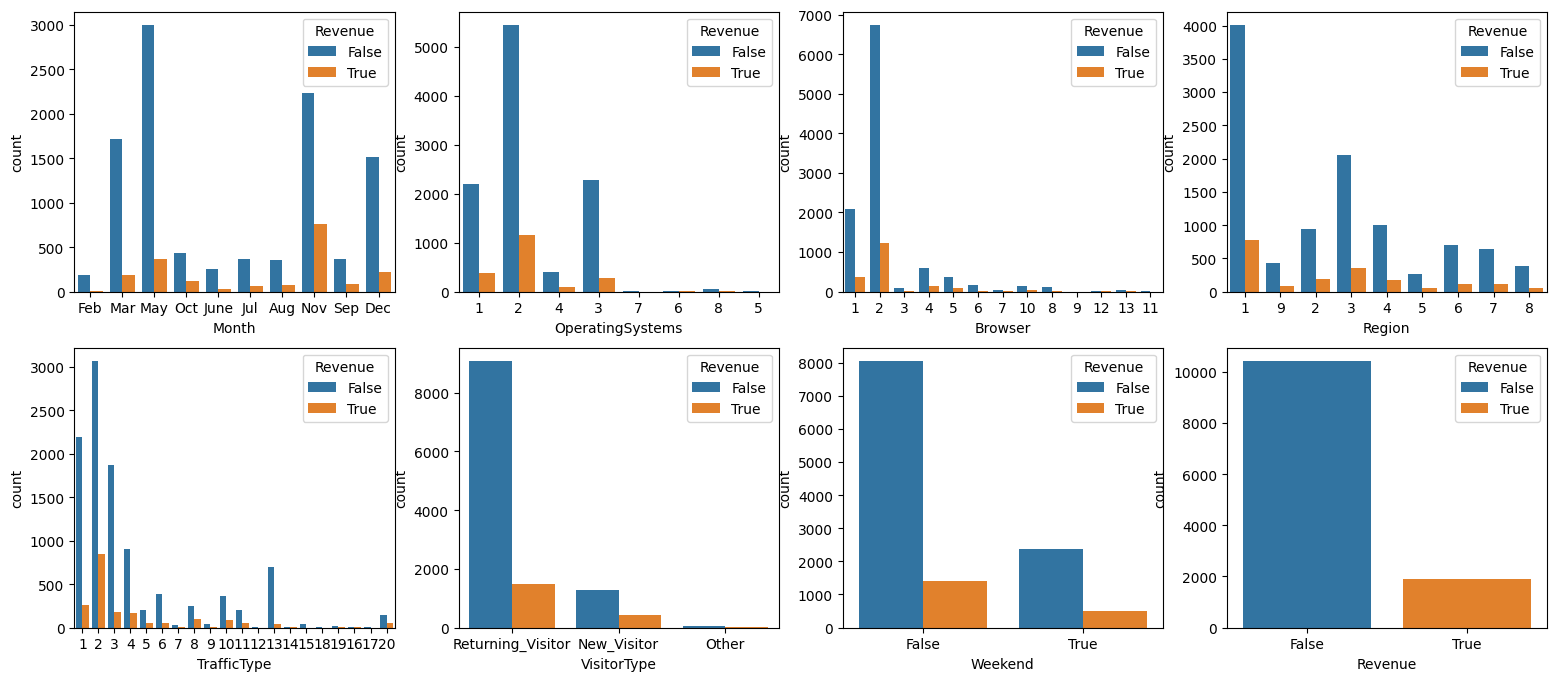

In [83]:
# distribuição das variáveis tipo categórico e booleano

fig, ax = plt.subplots(2, 4, figsize=(19, 8))

cat_cols = list(df.select_dtypes(include=['object', 'bool']).columns)

j = 0
i = 0

for col in cat_cols:

  if j < 4:

    sns.countplot(x=col, data=df, hue='Revenue', ax=ax[i][j])

    j = j + 1

  if j == 4:

    j = 0

    i = i + 1


In [84]:
# Veja se há valores missing e caso haja, decida o que fazer

df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

*A fim de selecionar as variáveis a serem utilizadas na elaboração do modelo de agrupamento, foram calculadas a correlação entre essas variáveis e o "Revenue"*

In [85]:
# Calculando a correlação entre as variáveis numéricas e a "Revenue"

df_num = df.select_dtypes(include=['float64', 'int64'])

for col in list(df_num.columns):

  print(f'{stats.pointbiserialr(df[col], df["Revenue"])[0]} - {col}')

0.13891709415067258 - Administrative
0.09358671905704188 - Administrative_Duration
0.09520034257205695 - Informational
0.07034450234598348 - Informational_Duration
0.1585379842808748 - ProductRelated
0.15237261055701037 - ProductRelated_Duration
-0.1506729119260537 - BounceRates
-0.20707108205527186 - ExitRates
0.4925692952512095 - PageValues
-0.08230459817953284 - SpecialDay


In [86]:
# Calculando a correlação entre as variáveis categóricas e a "Revenue"

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = stats.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))

# FONTE: https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix

In [87]:
# preparando os dados categóricos

df_cat = df.select_dtypes(include=['object', 'bool'])

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for i in df_cat.columns :
  data_encoded[i]=label.fit_transform(df_cat[i])

In [88]:
for col in list(data_encoded.columns):

  print(f'{cramers_V(data_encoded[col], data_encoded["Revenue"])} - {col}')

0.17669002313952925 - Month
0.07800589336761586 - OperatingSystems
0.047410905389247616 - Browser
0.027393902729961207 - Region
0.1739632864587674 - TrafficType
0.10473460176130583 - VisitorType
0.029029976284465523 - Weekend
0.999689970056086 - Revenue


*Selecionando as 6 variáveis que apresentam maiores correlações com "Revenue" e que descrevem o padrão de navegação na sessão, seguem: "PageValues", "TrafficType", "ExitRates", "ProductRelated", "ProductRelated_Duration", "BounceRates"*

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa.

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [89]:
# selecionando a features

df_modelo = df[["PageValues", "TrafficType", "ExitRates", "ProductRelated", "ProductRelated_Duration"]]

In [90]:
# padronizar os dados numéricos

df_modelo_num = df_modelo.select_dtypes(include=['float64', 'int64'])
padronizador = StandardScaler()
df_modelo_pad = pd.DataFrame(padronizador.fit_transform(df_modelo_num))

In [91]:
# dummies dados categóricos

df_dummies = pd.get_dummies(df_modelo[["TrafficType"]])

In [92]:
# mesclando e preparando os dados

df_dummies.reset_index(inplace=True)
df_modelo_pad.reset_index(inplace=True)

df_pad = df_modelo_pad.merge(df_dummies, how='left', on='index')

df_pad = df_pad.drop(['index'], axis=1)

df_pad.columns = ['PageValues', 'ExitRates', 'ProductRelated', 'ProductRelated_Duration'] + list(df_dummies.columns[1:])

In [93]:
# treinando o modelo com agrupamento por 3

clus = AgglomerativeClustering(linkage="complete",
                                 distance_threshold = None,
                                 n_clusters=3)

clus.fit(df_pad)

AgglomerativeClustering(linkage='complete', n_clusters=3)

<ipython-input-94-8d29d5b4ad40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['grupo'] = clus.labels_


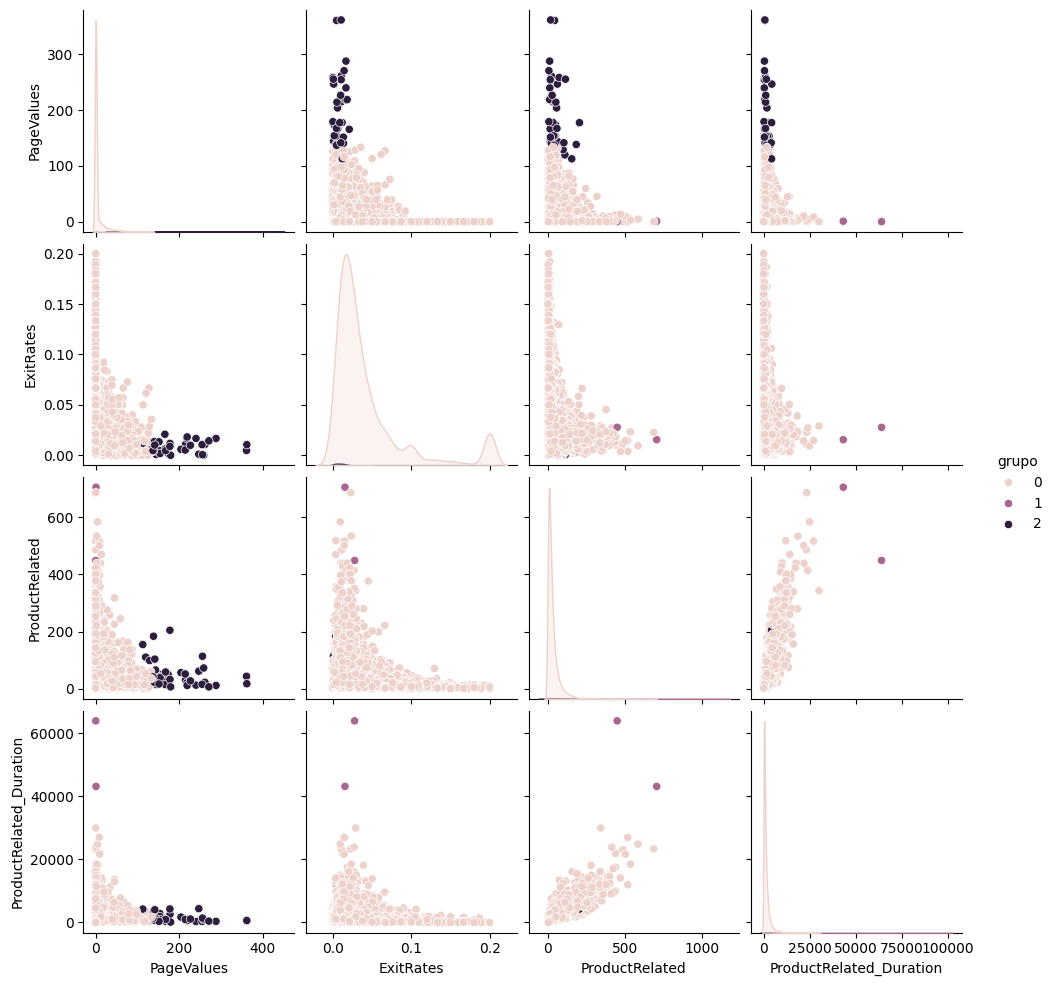

In [94]:
# visualizando o resultado com agrupamento por 4

df_modelo['grupo'] = clus.labels_

sns.pairplot(data=df_modelo, hue='grupo')

In [95]:
# treinando o modelo com agrupamento por 4

clus = AgglomerativeClustering(linkage="complete",
                                 distance_threshold = None,
                                 n_clusters=4)

clus.fit(df_pad)

AgglomerativeClustering(linkage='complete', n_clusters=4)

<ipython-input-96-1352768a5d63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['grupo_2'] = clus.labels_


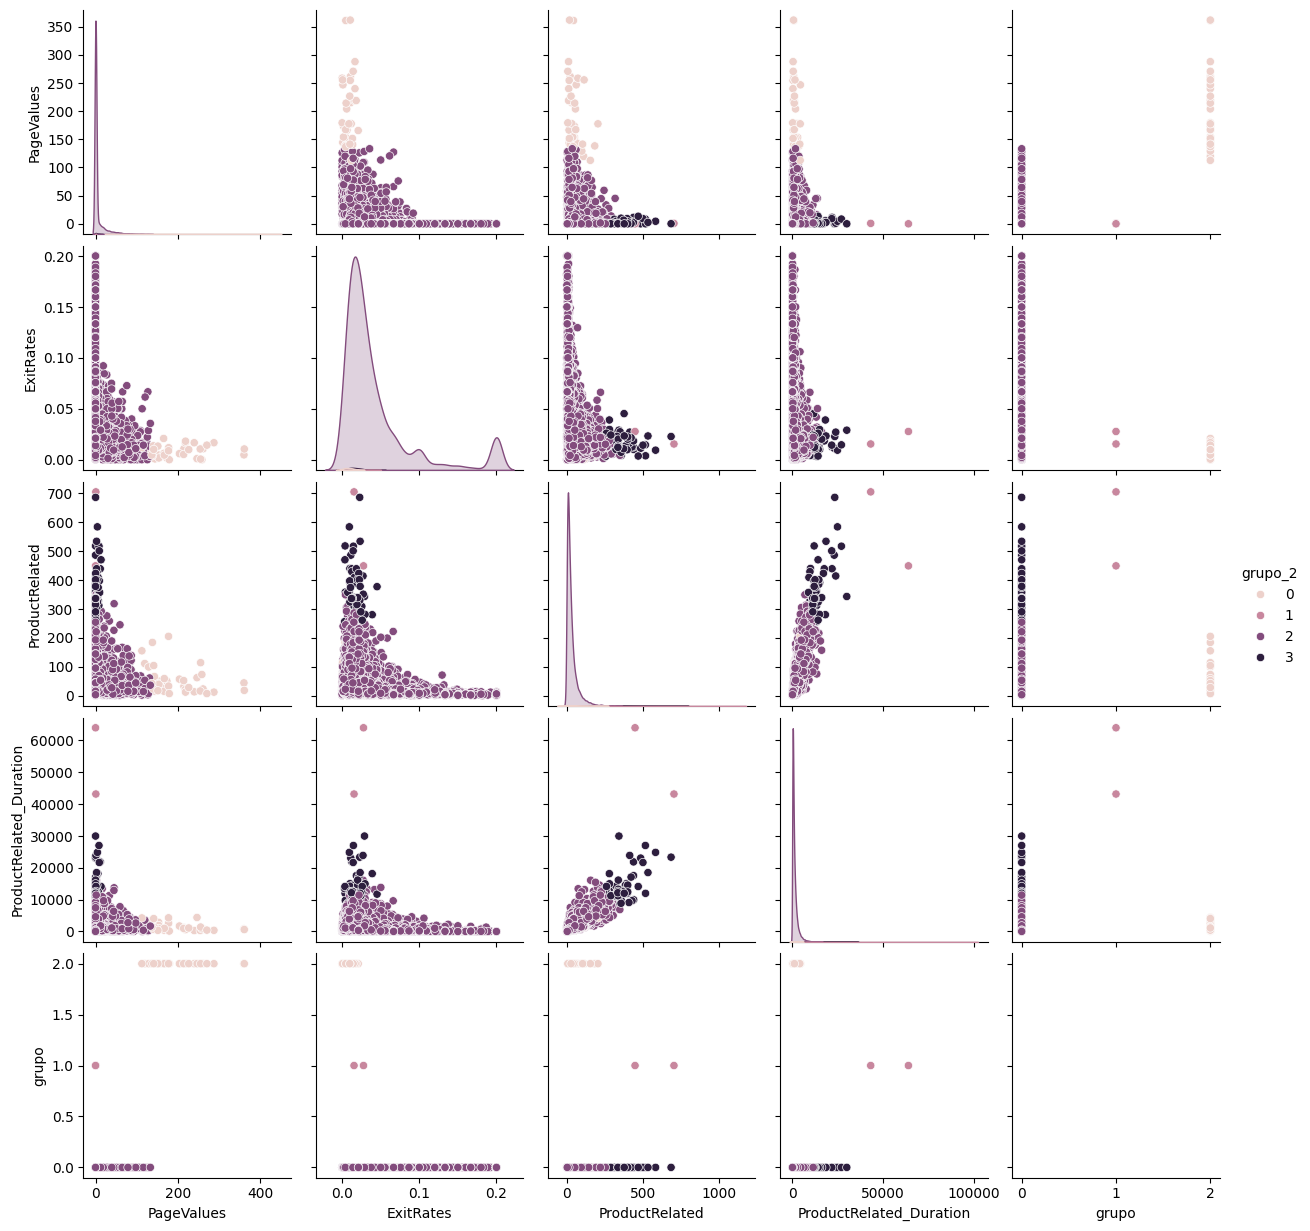

In [96]:
# visualizando o resultado com agrupamento por 4

df_modelo['grupo_2'] = clus.labels_

sns.pairplot(data=df_modelo, hue='grupo_2')

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

<Axes: xlabel='BounceRates', ylabel='Count'>

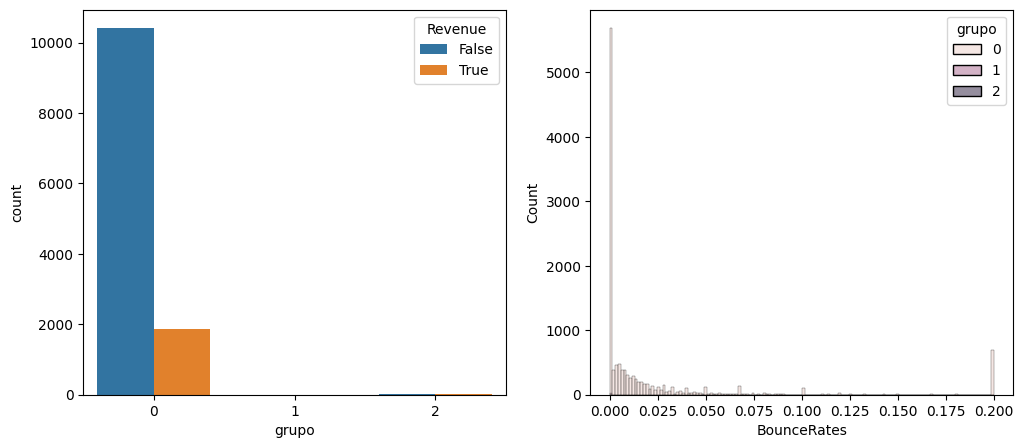

In [97]:
# Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente bounce rate e revenue)
df['grupo'] = df_modelo['grupo']

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='grupo', hue='Revenue', data=df, ax=ax[0])
sns.histplot(x='BounceRates', hue='grupo', data=df, ax=ax[1])



In [98]:
pd.crosstab(df['Revenue'], df['grupo'])

grupo,0,1,2
Revenue,,,
False,10413,2,7
True,1877,0,31


Qual grupo possui clientes mais propensos à compra?

*Fica evidente que o grupo 2 é mais propenso à compra*